## Linear Regression

Linear regression models are a good starting point for regression tasks. Such models are popular becasue they can be fir very quickly, and are very  interpretable. You are probably familiar with the simplest form of a linear regression model but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form

$$ y = ax + b $$

Where **a** is commonly known as the *slope*, and **b** is comonly known as the *intercept*

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

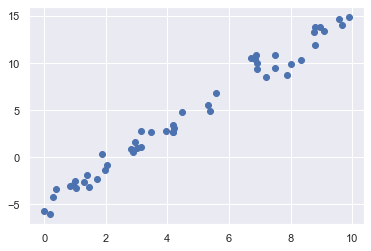

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We an use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line:

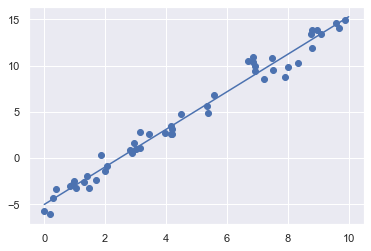

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are `coef_` and `intercept_`:

In [5]:
print("Model slope  ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope   2.0272088103606944
Model intercept: -4.9985770855532


We see that the results are very close to the inputs, as we might hope.

The `LinearRegression` estimator is much more capable than this, however--in addition to simple straight-line fits, it can also handle multidimensional linear models of the form

$$y=a_0 + a_{1}x_{1} + a_{2}x_{2} + ...$$

where there are multiple **x** values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to poitns in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [6]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

Here the **y** data is constructed from the three random **x** values, and the linear regression recovers the coefficients used to construct the data. 

In this way, we can use the single `LinearRegression` estimator to fit lines, planes or hyperplanes to our data. It still appears that this approach would be limited to stricly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data accordint to *basis functions*. We have seen one version of this before, in the `PolynomialRegression` pipeline used in other sections. The idea is to take our multidimensional linear model:
$$y = a_{0} + a_{1}x_{1} + a_{2}x_{2} + a_{3}x_{3} + ...$$

and build the **x_1, x_2, x_3** and so on, from our single-dimensional input **x**. That is, we let $x_n =f_n(x), where f_n()$ in some function that transform our data. For example , if $f_n(x) = x^n$, our model becomes a polynomial regression: $$y= a_0 + a_1x + a_2x^2 + a_3x^3 + ...$$

Notice that this is *still a linear model* - the linearity refers to the fact that the coefficients **a_n** never multiply or divide each other. What we have effectively done is taken our one-dimensional **x** values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between **x** and **y**.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the `PolynomialFeatures` transformer:

In [7]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value. This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in feature engineering, the cleanest way to accomplish this is to use a pipeline. Let's make a 7th-degree polynomial model in this way:

In [11]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this trasnform in palce, we can use the lienar model to fit much more complicated relationships between *x* and *y*. For example, here is a sine wave with noise:

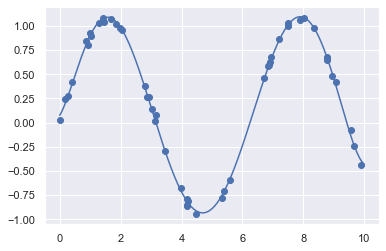

In [12]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.rand(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to his non-linear data!

### Gaussian basis functions

Of course oter basis functions are possible. For example, one useful pattern is to fit a model that is not a sum of oplynomial bases, but a sum of Gaussian bases. The result might look something like the following figure:

![gaussian_basis_function](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.06-gaussian-basis.png)

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. These GAussian baes functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, sa hown here nad illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

(0.0, 10.0)

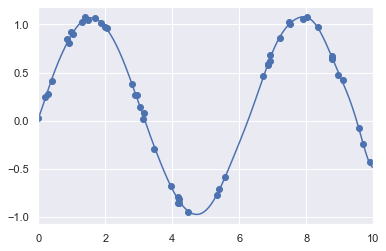

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10) 

Así sale en el ejemplo, no se porque no me sale igual:

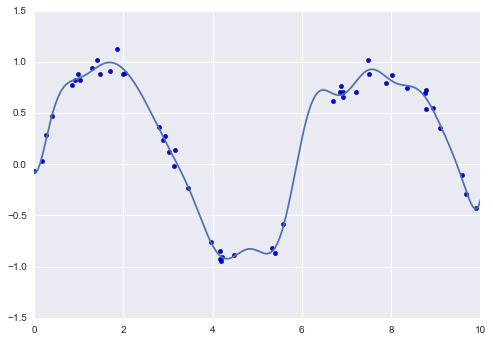

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.